# Image Statistics Measures on MediaEval Dataset



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob, os

In [2]:
test_df = pd.read_pickle('test.pkl')
test_df.head()

,tweetText,label,num_words,text_length,contains_questmark,num_questmark,contains_exclammark,num_exclammark,contains_happyemo,contains_sademo,...,num_friends,num_followers,folfriend_ratio,times_listed,has_url,is_verified,num_tweets,imageId,imagePath,event
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-03-20 17:44:11,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,13,116,0,0,0,0,0,0,...,207,276,1.333333,10,0,0,15564,eclipse_01,./MediaEval/mediaeval2015/testset/TestSetImage...,eclipse
2015-03-20 17:47:13,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,13,116,0,0,0,0,0,0,...,94,78,0.829787,0,0,0,1275,eclipse_01,./MediaEval/mediaeval2015/testset/TestSetImage...,eclipse
2015-03-20 09:03:24,Dit dus \0/ RT “@News_Executive: The Solar ecl...,0,15,139,0,0,0,0,0,0,...,422,880,2.085308,35,0,0,14196,eclipse_01,./MediaEval/mediaeval2015/testset/TestSetImage...,eclipse
2015-03-20 08:41:23,Photo: The Solar eclipse as seen from the Inte...,0,14,119,0,0,0,0,0,0,...,999,4007,4.011011,156,0,0,6709,eclipse_01,./MediaEval/mediaeval2015/testset/TestSetImage...,eclipse
2015-03-21 00:19:00,"“@planetepics: A solar eclipse, viewed from th...",0,16,111,0,0,0,0,0,0,...,296,357,1.206081,1,0,0,6256,eclipse_01,./MediaEval/mediaeval2015/testset/TestSetImage...,eclipse


In [3]:
img_array = test_df.groupby(['event', 'label'])['imagePath'].unique()
img_array

event    label
eclipse  0        [./MediaEval/mediaeval2015/testset/TestSetImag...
         1        [./MediaEval/mediaeval2015/testset/TestSetImag...
nepal    0        [./MediaEval/mediaeval2015/testset/TestSetImag...
         1        [./MediaEval/mediaeval2015/testset/TestSetImag...
Name: imagePath, dtype: object

## Visual Clarity Score

### Description
- VCS measures distribtion difference between two images sets (image set in a news event [event set] vs image set in all events [collection set])
- If event set is different from collection set, then it is likely to be real
- Compute two language models, one from event set and one from collection set and compute the KL divergence between the two language models
- Language model derived from bag-of-words representation

### Steps
1. Extract SIFT from each image
2. Use clustering methods (in this case, paper didn't specify which clutering, so I used K-means is used, i.e. K=200)
3. Create histogram of clustered word count for each image (bincount), the normalized the histogram to give $P(w|x)$
4. The event language model $P(w|k)$ can be defined as
$$P(w|k) = \sum\limits_{x \in R} P(w|x) P(x|k)$$
where
    - $w \in V$ is a visual word, $V$ is the visual word vocabulary
    - $R$ is image set of target event
    - $P(w|x)$ is defined as the term frequency of visual word $w$ in image $x$, this is computed by the histogram in step 3
    - $P(x|k) \propto P(k|x) P(x)$, where $P(k|x) = \mathbb{I}_{x\in R}$
5. Get the visual clarity score by computing the KL divergence between the event set and the collection set, is given by
$$\text{VCS}(k) =D_{KL}(P(w|x) || P(w|c))$$
$$=\sum\limits_{w \in V} P(w|k) \log \frac{P(w|k)}{P(w|c)}$$
where
    - $P(w|c)$ is defined as the term frequency of visual word over images in all news event
    
### Note
- No K is specified for the K-Means clustering in the paper. The authors also didn't specify which clustering algorithm they used. It may be possible to improve the model performance by (i) using another clustering algorithm such as DBScan which do not require the K term, (ii) using GridSearchCV to find the best K term

1. SIFT for all images
2. Keep track of events in file
3. KMeans fit all the images
4. KMean predict for individual event
5. KL divergence on the histogram distribution

In [7]:
import cv2

# Look through each directory and extract SIFT information from each picture
# and append all the SIFT information of images in a single event to list
# Can skip

img_desc = []

for d in img_array:
    event_desc = np.empty((0, 128))
    for f in d:
        im = cv2.imread(f)
        imGrey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        keypoint, desc = sift.detectAndCompute(imGrey, None)
        event_desc = np.r_[event_desc, desc]
    img_desc.append(event_desc)

In [8]:
# Stack all the events into a single numpy array for clustering
# Can skip

img_arr = np.empty((0, 128))

for i in img_desc:
    img_arr = np.r_[img_arr, i]
    
img_arr.shape

(47143, 128)

In [10]:
from sklearn.externals import joblib

N_CLUSTERS = 200
kmeans = joblib.load('kmeans.joblib')

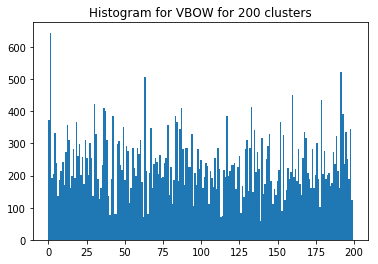

In [11]:
# Get the predicted cluster and do bincount
# Normalize the bincount to get the PMF of P(w|c) by dividing with the total number of descriptors
# Can skip

clustered = kmeans.predict(img_arr)
total_pmf = np.bincount(clustered, minlength = N_CLUSTERS) / img_arr.shape[0]
plt.title('Histogram for VBOW for {} clusters'.format(N_CLUSTERS))
plt.hist(clustered, bins = N_CLUSTERS)
plt.show()

In [12]:
# For each event, from each descriptor, predict which cluster
# does the descriptor belong to. On the event level, get the total bincount of all the clusters
# and normalize the bincount to get PMF of P(w|x) by dividing by the number of descriptors in the event
# Can skip

kld_list = []
for i in img_desc:
    event_cluster = kmeans.predict(i)
    event_pmf = np.bincount(event_cluster, minlength = N_CLUSTERS) / i.shape[0]
    kl_div = np.sum(event_pmf * np.log1p(np.true_divide(event_pmf, total_pmf)))
    kld_list.append(kl_div)

In [13]:
img_df = pd.DataFrame(kld_list, index = img_array.index, columns = ['VCS'])
img_df

VCS
event   label          
eclipse 0      0.961935
        1      1.170985
nepal   0      0.703927
        1      0.700620

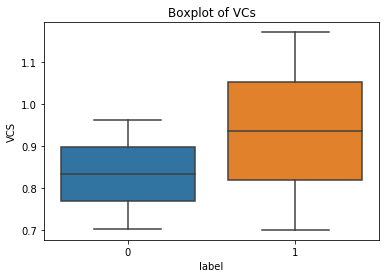

In [14]:
# Plot VCS into boxplot to show the difference of VCS between real and fake events
# Can skip

sns.boxplot(x = 'label', y = 'VCS', data = img_df.reset_index())
plt.title('Boxplot of VCs')
plt.show()

## Visual Coherence Score

### Description
- This measures how coherent the images are in a certain news event
- Since relevant images tend to share common visual pattern, they are more visually similar
- Images in fake news event are more coherent and less diverse
- Cosine similarity is used to compute similarity

### Steps
1. Get the 960-dimensional GIST features for the images
2. For each image in the event set, compute the VCoS
$$\text{VCos} (x) = \frac{1}{|N(N-1)|} \sum\limits_{i,j=1,\cdots,T;i\neq j}sim(x_i, x_j)$$

### Note
- In the paper, the author uses a 512 dimensional GIST feature vector, however, I tried a 960 dimensional GIST from the GIST library
- More time and effort can be spent to develop the GIST feature library from scratch, if more focus is required on this area
- Folder with lesser than 2 pictures will be not processed, since VCoS cannot be computed

In [15]:
# Append GIST module path to sys path

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

import gist

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

vcos_list = []

for d in img_array:
    for idx, f in enumerate(d):
        im = Image.open(f)
        desc = gist.extract(np.array(im))
        if idx == 0:
            joint_desc = np.atleast_2d(desc)
        else:
            joint_desc = np.vstack([joint_desc, desc])
            
    N = d.shape[0]
    vcos = 1 / (N * (N-1)) * np.sum(np.triu(cosine_similarity(joint_desc)))
    vcos_list.append(vcos)

In [17]:
vcos = pd.Series(vcos_list, index = img_array.index, name = 'VCoS')
vcos

event    label
eclipse  0        0.583111
         1        0.709788
nepal    0        0.453399
         1        0.473203
Name: VCoS, dtype: float64

In [18]:
img_df = pd.concat([img_df, vcos], axis = 1)
img_df

VCS      VCoS
event   label                    
eclipse 0      0.961935  0.583111
        1      1.170985  0.709788
nepal   0      0.703927  0.453399
        1      0.700620  0.473203

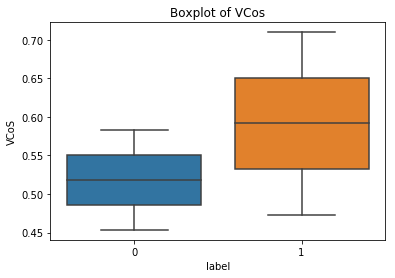

In [19]:
sns.boxplot(x = 'label', y = 'VCoS', data = img_df.reset_index())
plt.title('Boxplot of VCos')
plt.show()

## Visual Similarity Distribution Histogram

### Description
- The VSDH can describe image similarity distribution has finer granularity than VCos
- For an event set $R$, there is a visual similarity matrix $M \in \mathbb{R}^{N \times N}$
- $m_{ij} \in M$ is the visual similarity between images
- Images are ranked based on their similarity (in this case, the images are ranked based on the number of times it appears in tweets)
- Compute $m_{ij}$ similarity is computed as per VCoS
- Quantified it into H-bin (in this case H = 10)

### Steps
1. As per VCoS, get 960 dimensional GIST from image
2. Rank the images are per the number of occurence in the text
3. Compute cosine similarity between $x_i$ and $x_j$
4. Compute 10-bin histogram by mapping each element into its bin
$$VSDH(h) = \frac{1}{N^2} \left| {(i,j)} | i,j \leq N, m_{ij} \in \text{h-th bin}\right|$$
5. $VSDH(k) = \text{h-th bin}$

#### Extract VSDH and VDS for all images

In [20]:
histList = []
vdsList = []

for d in img_array:
    N = d.shape[0]
    for idx, f in enumerate(d):
        im = Image.open(f)
        desc = gist.extract(np.array(im))
        if idx == 0:
            joint_desc = np.atleast_2d(desc)
        else:
            joint_desc = np.vstack([joint_desc, desc])

    cos_sim = cosine_similarity(joint_desc)
    
    # 10-bin Histogram
    cos_sim_flat = np.tril(cos_sim).flatten()
    histList.append(cos_sim_flat)
    
    # Get dissimilarity matrix
    dis_sim = 1 - cos_sim 
    vds = np.sum(np.sum(np.tril(dis_sim), axis = 1) / (np.arange(dis_sim.shape[0]) + 1))
    vdsList.append(vds)

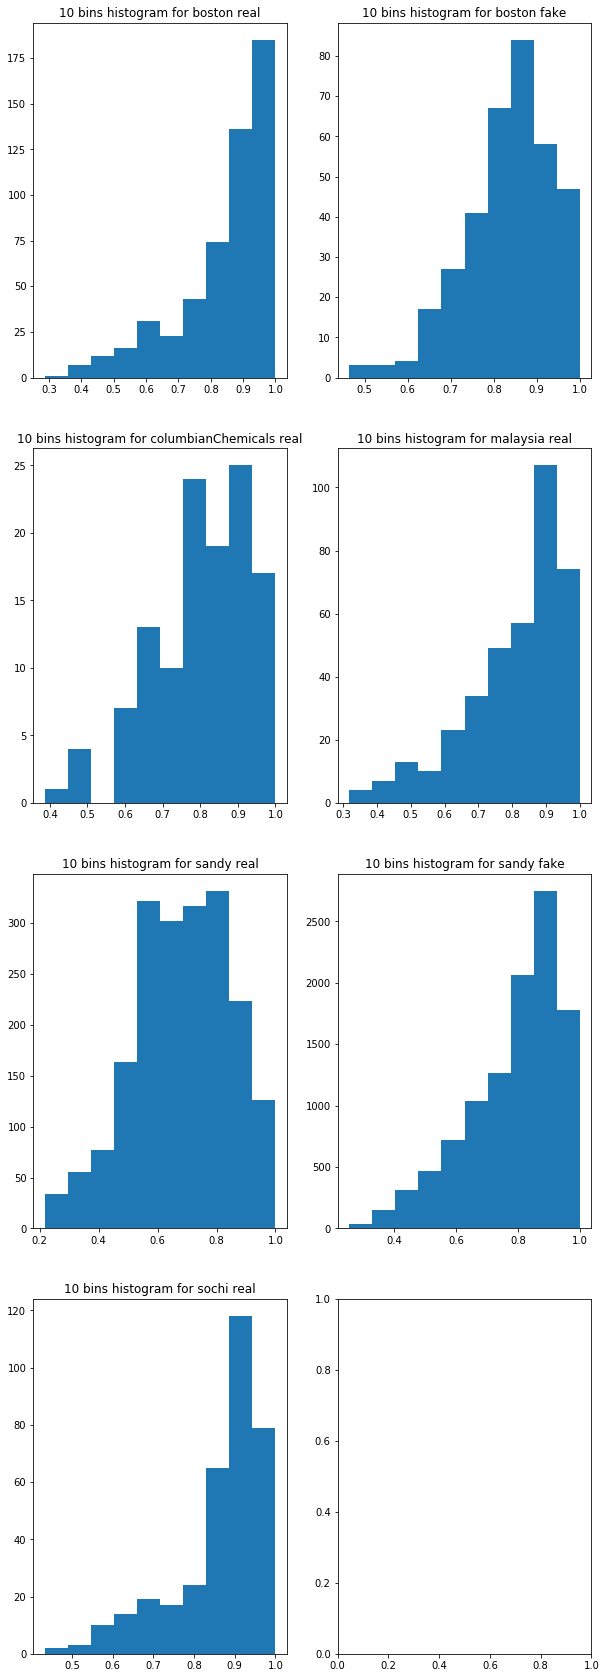

In [127]:
hist_len = len(histList)

fig, ax = plt.subplots(nrows = int(np.ceil(hist_len / 2)), ncols = 2, figsize = (10, 30))

for i, f in enumerate(img_array.index):
    event = f[0]
    label = 'real'
    if f[1] == 1:
        label = 'fake'
    ax[int(i/2), i%2].hist(histList[i][np.nonzero(histList[i])], bins = 10)
    ax[int(i/2), i%2].set_title('10 bins histogram for {} {}'.format(event, label))

## Visual Diversity Score

### Description
- VDS measures the visual difference in the images in the event set, it compute image diversity more directly than VCoS and more emphasis on represntative images
- Diversity of an image is the minimal difference with the image ranking before it
- The images are ranked as per VSDH
- The dissimilarity between images are then computed in the position $i$ and $j$ by taking the complementary of similarity
- The VCos take the average similarity, but VDS is a weighted average of similarity, as VSD give more emphasis to the top-ranked images
- Hence, VDS reduce the impact of noise images

### Steps
1. Same as VSDH (1)
2. Same as VSDH (2)
3. Compute dissimilarity as given by
$$dis(x_i, x_j) = 1 - sim(x_i, x_j)$$
4. The visual diversity score is then computed by
$$\text{VDS}(k) = \sum\limits_{i=1}^{N} \frac{1}{i} \sum\limits_{j=1}^{i} dis(x_i, x_j)$$

#### Example of SandyA Real

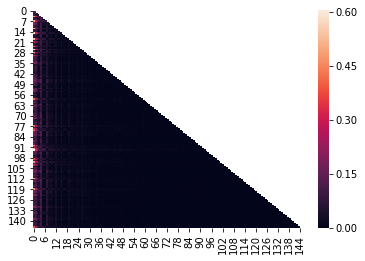

In [128]:
mask = np.zeros_like(sandy_dis_sim, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sandy_vds = np.tril(sandy_dis_sim) * (1 / (np.arange(sandy_dis_sim.shape[0]) + 1))

sns.heatmap(sandy_vds, mask = mask)

In [129]:
sandy_vds_sum = np.sum(np.sum(np.tril(dis_sim), axis = 1) / (np.arange(dis_sim.shape[0]) + 1))

print ('Visual Diversity Score for SandyA Real is {}'.format(sandy_vds_sum))

Visual Diversity Score for SandyA Real is 3.2196965900557424


In [131]:
vds = pd.Series(vdsList, index = img_array.index, name = 'VDS')
vds

event               label
boston              0         4.129190
                    1         3.941849
columbianChemicals  0         2.534407
malaysia            0         5.250847
sandy               0        18.899307
                    1        31.127527
sochi               0         3.219697
Name: VDS, dtype: float64

In [132]:
img_df = pd.concat([img_df, vds], axis = 1)
img_df

VCS      VCoS        VDS
event              label                               
boston             0      0.714928  0.448832   4.129190
                   1      0.722243  0.452021   3.941849
columbianChemicals 0      0.743426  0.462381   2.534407
malaysia           0      0.810919  0.436661   5.250847
sandy              0      0.709435  0.353685  18.899307
                   1      0.702138  0.399166  31.127527
sochi              0      0.780510  0.466992   3.219697

In [134]:
img_df.to_pickle('img_diversity.pkl')